In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv',
                 encoding = 'ISO-8859-1',
                 parse_dates=["InvoiceDate"],
                 low_memory=False)
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")

Loaded 541909 rows and 8 columns


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
for col in ["CustomerID", "Description"]:
  pct_missing = df[col].isna().mean() *100
  print(f"{pct_missing} of {col} values are missing")

24.926694334288598 of CustomerID values are missing
0.2683107311375157 of Description values are missing


In [ ]:
for col in ["Quantity", "UnitPrice"]:
  bad = (df[col] <= 0).sum()
  print(f"{col} has {bad} bad values")

Quantity has 10624 bad values
UnitPrice has 2517 bad values


In [ ]:
df_clean = df.dropna(subset=["Description", "CustomerID"])
print(f"after dropping missing fields {df_clean.shape[0]} rows remain")


after dropping missing fields 406829 rows remain


In [ ]:
df_sales = df_clean.query("Quantity > 0 and UnitPrice > 0").copy()

print(f"after dropping sales {df_sales.shape[0]} rows remain")

after dropping sales 397884 rows remain


In [ ]:
df_net = df_clean.query("UnitPrice > 0").copy()

print(f"after dropping net {df_net.shape[0]} rows remain")

after dropping net 406789 rows remain


In [ ]:
for d in (df_sales, df_net):
  d["TotalPrice"] = d["Quantity"] * d["UnitPrice"]

df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
total_rev = df_net["TotalPrice"].sum()
total_items = df_sales["Quantity"].sum()
print(f"Net rev: {total_rev:.2f}")
print(f"Total items: {total_items:,}")

Net rev: 8300065.81
Total items: 5,167,812


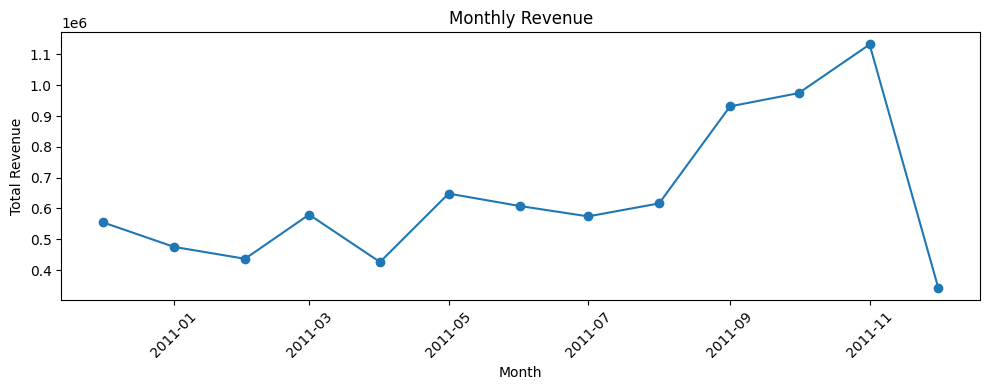

In [ ]:
df_net["Month"] = df_net["InvoiceDate"].dt.to_period("M")
monthly_rev = df_net.groupby("Month")["TotalPrice"].sum().to_timestamp()
plt.figure(figsize=(10,4))
plt.plot(monthly_rev.index, monthly_rev.values, marker = "o")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Monthly Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

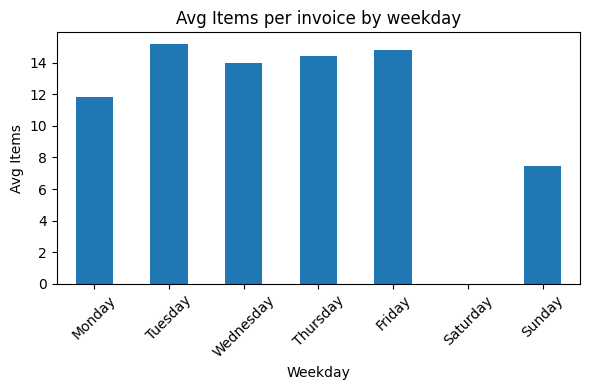

In [ ]:
df_sales["Weekday"] = df_sales["InvoiceDate"].dt.day_name()
weekday_avg = (df_sales.groupby("Weekday")["Quantity"]
               .mean()
               .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
               )
plt.figure(figsize=(6,4))
weekday_avg.plot(kind="bar")
plt.title("Avg Items per invoice by weekday")
plt.ylabel("Avg Items")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
top_by_qty = df_sales.groupby("Description")["Quantity"].sum().nlargest(10)
top_by_rev = df_sales.groupby("Description")["TotalPrice"].sum().nlargest(10)
print(top_by_qty)
print(top_by_rev)

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64
Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: fl

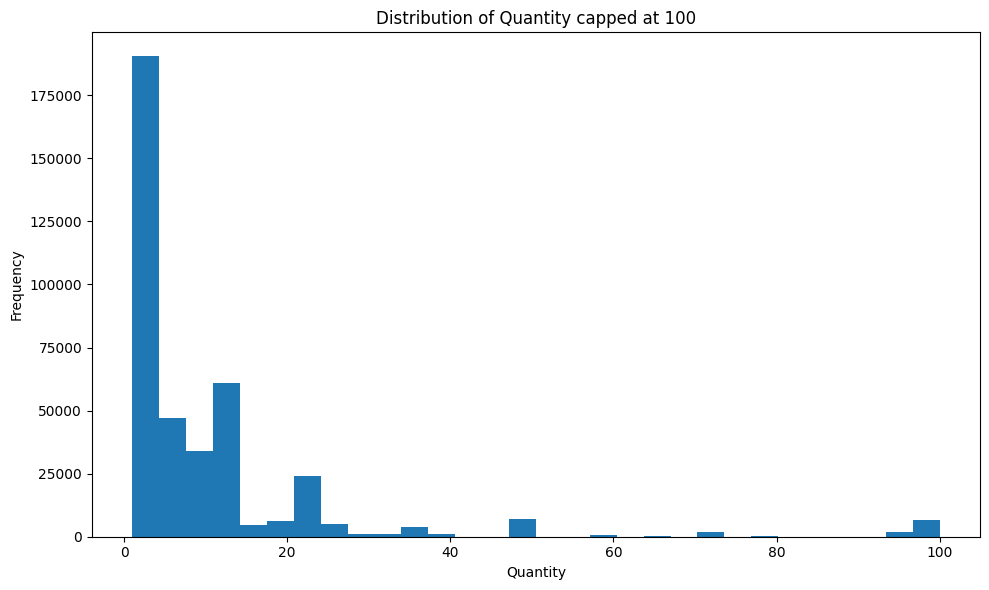

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_sales["Quantity"].clip(upper=100), bins = 30)
plt.title("Distribution of Quantity capped at 100")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

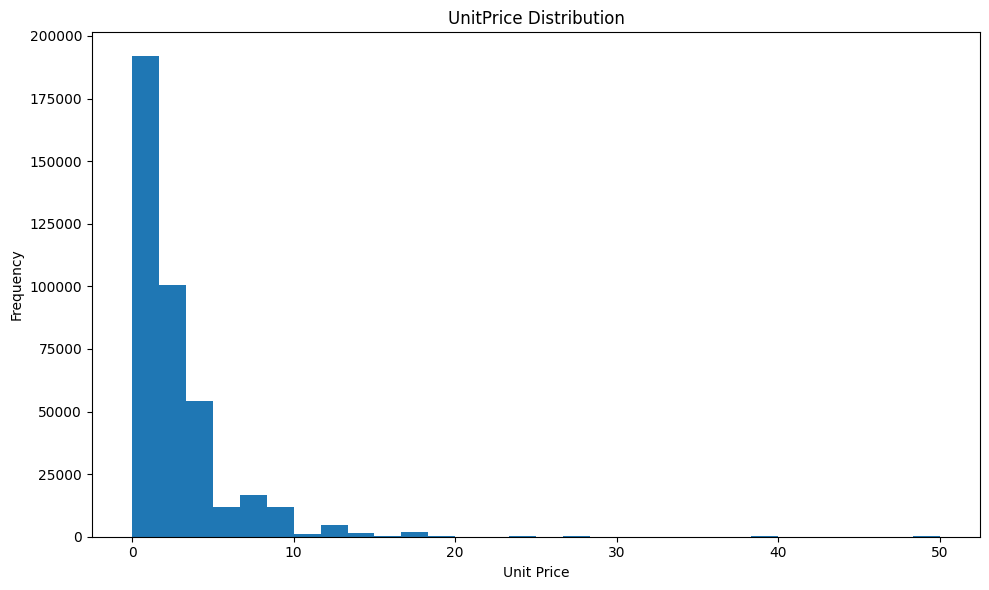

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_sales["UnitPrice"].clip(upper=50), bins=30)
plt.title("UnitPrice Distribution")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
cust_order = df_sales.groupby("CustomerID")["InvoiceNo"].nunique()
repeat_rate = (cust_order > 1).mean()
one_time = (cust_order == 1).mean()
print(cust_order.size)
print(f"Repeat rate: {repeat_rate:.2%}")
print(f"One time rate: {one_time:.2%}")

4338
Repeat rate: 65.58%
One time rate: 34.42%


In [ ]:
cust_rev = df_sales.groupby("CustomerID")["TotalPrice"].sum()
print(cust_rev.mean())


2054.2664601198708


Text(0, 0.5, 'Total Revenue')

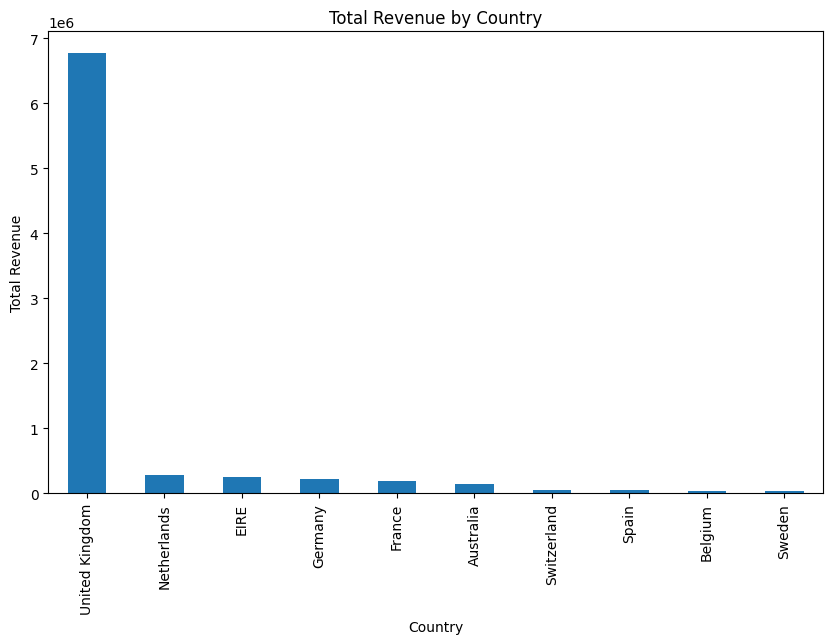

In [ ]:
country_rev = df_net.groupby("Country")["TotalPrice"].sum().nlargest(10)
plt.figure(figsize=(10, 6))
country_rev.plot(kind="bar")
plt.title("Total Revenue by Country")
plt.xlabel("Country")
plt.ylabel("Total Revenue")

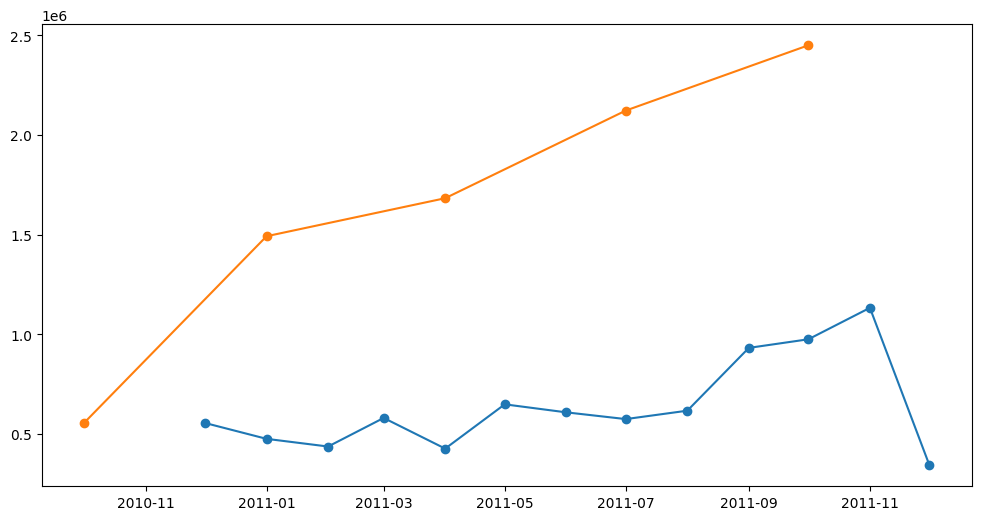

In [ ]:
# seasonality and time series

monthly_rev = df_net.groupby(df_net["InvoiceDate"].dt.to_period("M"))["TotalPrice"].sum().to_timestamp()
quarterly_rev = df_net.groupby(df_net["InvoiceDate"].dt.to_period("Q"))["TotalPrice"].sum().to_timestamp()
plt.figure(figsize=(12, 6))
plt.plot(monthly_rev.index, monthly_rev.values, marker="o", label="Monthly")
plt.plot(quarterly_rev.index, quarterly_rev.values, marker="o", label="Quarterly")

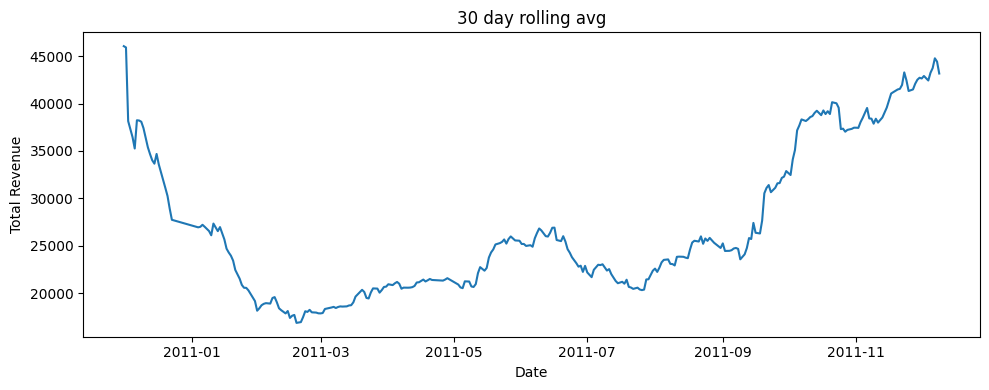

In [ ]:
daily_net = df_net.groupby(df_net["InvoiceDate"].dt.date)["TotalPrice"].sum()
rolling_30 = daily_net.rolling(window = 30, min_periods =1).mean()
plt.figure(figsize=(10,4))
plt.plot(rolling_30.index, rolling_30.values)
plt.title("30 day rolling avg")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()